In [1]:
import time
import numpy as np
from tqdm import tqdm
import timm
import torch
from torchvision import models as torchvision_models
import matplotlib.pyplot as plt

/Users/taile/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def benchmark(model, input_shape=(1, 3, 224, 224), dtype='fp32', nruns=100, device='cpu'):
    input_data = torch.randn(input_shape).to(device)
    if dtype == 'fp16':
        input_data = input_data.half()
    with torch.no_grad():
        for _ in range(10):
            features = model(input_data)

    timings = []
    with torch.no_grad():
        for _ in tqdm(range(nruns)):
            start_time = time.time()
            pred = model(input_data)
            end_time = time.time()
            timings.append(end_time - start_time)
    end_time = time.time()
    prep_time = end_time - start_time
    fps = input_shape[0]/np.mean(timings)
    return fps, prep_time

model_lst = ['resnet18', 'resnet50','mobilenet_v2', 'squeezenet1_0', 'vgg16', 'efficientnet_b0', 'efficientnet_lite0']
opt_lst = ['pytorch', 'torchscript', 'low_res']

In [5]:


nruns = 100
input_shape = (1, 3, 224, 224)

benchmark_res = dict()
prep_res = dict()
for model_name in model_lst:
    print(f"Benchmarking {model_name}...")

    if model_name == 'resnet18':
        model = torchvision_models.resnet18(weights=torchvision_models.ResNet18_Weights.DEFAULT).eval()
    elif model_name == 'mobilenet_v2':
        model = torchvision_models.mobilenet_v2(weights=torchvision_models.MobileNet_V2_Weights.DEFAULT).eval()
    elif model_name == 'squeezenet1_0':
        model = torchvision_models.squeezenet1_0(weights=torchvision_models.SqueezeNet1_0_Weights.DEFAULT).eval()
    elif model_name == 'vgg16':
        model = torchvision_models.vgg16(weights=torchvision_models.VGG16_Weights.DEFAULT).eval()
    elif model_name == 'resnet50':
        model = torchvision_models.resnet50(weights=torchvision_models.ResNet50_Weights.DEFAULT).eval()
    elif model_name == 'efficientnet_b0':
        model = timm.create_model('efficientnet_b0', pretrained=True).eval()
    elif model_name == 'efficientnet_lite0':
        model = timm.create_model('efficientnet_lite0', pretrained=True).eval()
    else:
        raise RuntimeError(f'Model "{model_name}" not recognized.')

    benchmark_res[model_name] = dict()
    prep_res[model_name] = dict()

    fps1, prep1 = benchmark(model, input_shape=input_shape, nruns=nruns, device='cpu')
    # Torchscrip the model
    scripted_model = torch.jit.script(model)
    fps2, prep2 = benchmark(scripted_model, input_shape=input_shape, nruns=nruns, device='cpu')
    # Simulate optimization by reducing input resolution
    low_res_shape = (input_shape[0], input_shape[1], input_shape[2] // 2, input_shape[3] // 2)
    fps3, prep3 = benchmark(model, input_shape=low_res_shape, nruns=nruns, device='cpu')
    print(f"Pytorch: {fps1:.4f}image/s, Torchscript: {fps2:.4f} image/s, Low res: {fps3:.4f} image/s")
    print(f"Pytorch prep: {prep1:.4f} s, Torchscript prep: {prep2:.4f} s, Low res prep: {prep3:.4f}")
    
    benchmark_res[model_name]['pytorch'] = fps1
    benchmark_res[model_name]['torchscript'] = fps2
    benchmark_res[model_name]['low_res'] = fps3
    prep_res[model_name]['pytorch'] = prep1
    prep_res[model_name]['torchscript'] = prep2
    prep_res[model_name]['low_res'] = prep3
    



Benchmarking resnet18...


100%|██████████| 100/100 [00:01<00:00, 77.07it/s]


Pytorch: 53.3617image/s, Torchscript: 49.1232 image/s, Low res: 77.4998 image/s
Pytorch prep: 0.0169 s, Torchscript prep: 0.0186 s, Low res prep: 0.0116
Benchmarking resnet50...


100%|██████████| 100/100 [00:01<00:00, 52.26it/s]


Pytorch: 25.7696image/s, Torchscript: 24.1567 image/s, Low res: 52.4887 image/s
Pytorch prep: 0.0406 s, Torchscript prep: 0.0353 s, Low res prep: 0.0182
Benchmarking mobilenet_v2...


100%|██████████| 100/100 [00:04<00:00, 21.76it/s]


Pytorch: 20.4479image/s, Torchscript: 20.6573 image/s, Low res: 21.8580 image/s
Pytorch prep: 0.0551 s, Torchscript prep: 0.0537 s, Low res prep: 0.0396
Benchmarking squeezenet1_0...


100%|██████████| 100/100 [00:00<00:00, 134.81it/s]


Pytorch: 61.7091image/s, Torchscript: 54.5826 image/s, Low res: 135.5328 image/s
Pytorch prep: 0.0180 s, Torchscript prep: 0.0181 s, Low res prep: 0.0071
Benchmarking vgg16...


100%|██████████| 100/100 [00:03<00:00, 32.36it/s]


Pytorch: 11.9026image/s, Torchscript: 13.1076 image/s, Low res: 32.4985 image/s
Pytorch prep: 0.0876 s, Torchscript prep: 0.0679 s, Low res prep: 0.0309
Benchmarking efficientnet_b0...


100%|██████████| 100/100 [00:29<00:00,  3.39it/s]


Pytorch: 3.1448image/s, Torchscript: 3.1828 image/s, Low res: 3.3951 image/s
Pytorch prep: 0.3135 s, Torchscript prep: 0.3051 s, Low res prep: 0.2796
Benchmarking efficientnet_lite0...


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]

Pytorch: 2.9633image/s, Torchscript: 3.1246 image/s, Low res: 3.0272 image/s
Pytorch prep: 0.3260 s, Torchscript prep: 0.3574 s, Low res prep: 0.3174


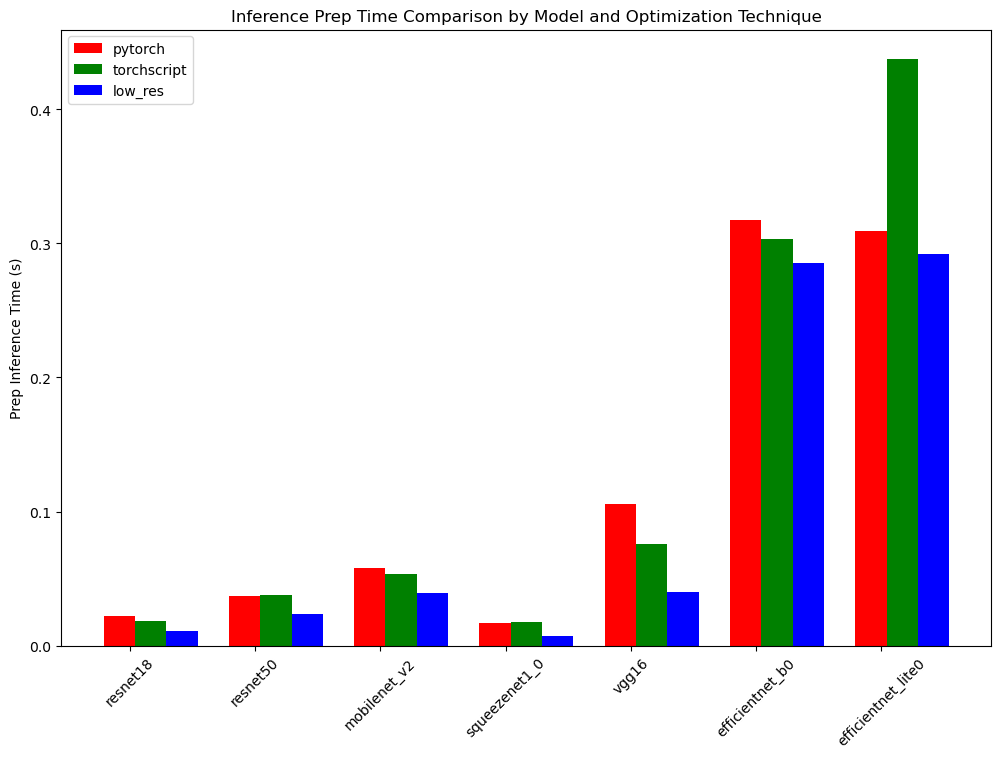

In [ ]:
colors = ['red', 'green', 'blue'] 
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.25 
x = np.arange(len(model_lst))

for i, opt_method in enumerate(opt_lst):
    times = [prep_res[model][opt_method] for model in model_lst]
    ax.bar(x + i * width, times, width, label=opt_method, color=colors[i])

ax.set_ylabel('Prep Inference Time (s)')
ax.set_title('Inference Prep Time Comparison by Model and Optimization Technique')
ax.set_xticks(x + width / len(opt_lst))
ax.set_xticklabels(model_lst)
ax.legend()

plt.xticks(rotation=45)
plt.show()

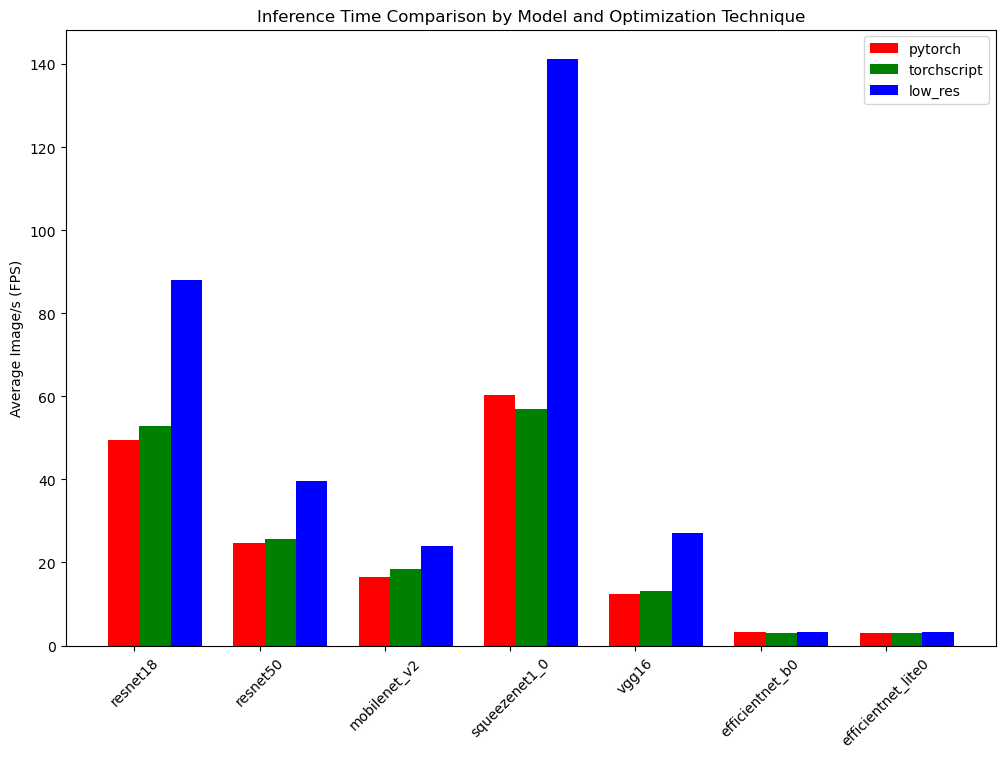

In [ ]:


fig, ax = plt.subplots(figsize=(12, 8))
width = 0.25  
x = np.arange(len(model_lst))

for i, opt_method in enumerate(opt_lst):
    times = [benchmark_res[model][opt_method] for model in model_lst]
    ax.bar(x + i * width, times, width, label=opt_method, color=colors[i])

ax.set_ylabel('Average Image/s (FPS)')
ax.set_title('Inference Time Comparison by Model and Optimization Technique')
ax.set_xticks(x + width / len(opt_lst))
ax.set_xticklabels(model_lst)
ax.legend()

plt.xticks(rotation=45)
plt.show()


In [18]:
from torchvision import datasets, transforms, models as torchvision_models
from torch.utils.data import DataLoader
from torch import optim, nn

# Original transformation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Transformation for lower resolution simulation
lowres_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((112, 112)),  # Lower resolution
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
fashion_mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
fashion_mnist_lowres_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=lowres_transform)

# DataLoader for original and low-res tests
test_loader = DataLoader(fashion_mnist_test, batch_size=64, shuffle=False)
test_loader_lowres = DataLoader(fashion_mnist_lowres_test, batch_size=64, shuffle=False)
train_loader = DataLoader(fashion_mnist_test, batch_size=64, shuffle=True)
train_loader_lowres = DataLoader(fashion_mnist_lowres_test, batch_size=64, shuffle=True)



def evaluate_accuracy(model, data_loader, device='mps'):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating Accuracy"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
num_epochs = 5


In [19]:
model = torchvision_models.resnet18(weights=torchvision_models.ResNet18_Weights.DEFAULT).eval()

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) 
model = model.to(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0
            
            

original_accuracy = evaluate_accuracy(model, test_loader, device=device)
print(f'Original {model_name} Accuracy: {original_accuracy}%')

scripted_model = torch.jit.script(model)
scripted_accuracy = evaluate_accuracy(scripted_model, test_loader, device=device)
print(f'TorchScript {model_name} Accuracy: {scripted_accuracy}%')

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader_lowres, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

lowres_accuracy = evaluate_accuracy(model, test_loader_lowres, device=device)
print(f'Low-Res {model_name} Accuracy: {lowres_accuracy}%')



Epoch 1, Batch 100, Loss: 0.9110789254307747
Epoch 2, Batch 100, Loss: 0.45617969483137133
Epoch 3, Batch 100, Loss: 0.3683726991713047
Epoch 4, Batch 100, Loss: 0.32436741068959235
Epoch 5, Batch 100, Loss: 0.2804472633451223


Evaluating Accuracy: 100%|██████████| 157/157 [00:02<00:00, 61.12it/s]


Original efficientnet_lite0 Accuracy: 90.9%


Evaluating Accuracy: 100%|██████████| 157/157 [00:02<00:00, 72.55it/s]


TorchScript efficientnet_lite0 Accuracy: 90.9%
Epoch 1, Batch 100, Loss: 0.6130647119879723
Epoch 2, Batch 100, Loss: 0.32396636888384817
Epoch 3, Batch 100, Loss: 0.24458479315042495
Epoch 4, Batch 100, Loss: 0.20120415825396776
Epoch 5, Batch 100, Loss: 0.16354774355888366


Evaluating Accuracy: 100%|██████████| 157/157 [00:09<00:00, 16.43it/s]

Low-Res efficientnet_lite0 Accuracy: 94.05%


In [26]:
model = torchvision_models.mobilenet_v2(weights=torchvision_models.MobileNet_V2_Weights.DEFAULT).eval()
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5), 
    nn.Linear(num_ftrs, 10)
)
model = model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0


original_accuracy = evaluate_accuracy(model, test_loader, device=device)
print(f'Original {model_name} Accuracy: {original_accuracy}%')

scripted_model = torch.jit.script(model)
scripted_accuracy = evaluate_accuracy(scripted_model, test_loader, device=device)
print(f'TorchScript {model_name} Accuracy: {scripted_accuracy}%')

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader_lowres, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

lowres_accuracy = evaluate_accuracy(model, test_loader_lowres, device=device)
print(f'Low-Res {model_name} Accuracy: {lowres_accuracy}%')



Epoch 1, Batch 100, Loss: 2.3041914463043214
Epoch 2, Batch 100, Loss: 2.3043606996536257
Epoch 3, Batch 100, Loss: 2.30343857049942
Epoch 4, Batch 100, Loss: 2.304874670505524
Epoch 5, Batch 100, Loss: 2.306184158325195


Evaluating Accuracy: 100%|██████████| 157/157 [00:02<00:00, 52.83it/s]


Original efficientnet_lite0 Accuracy: 15.67%


Evaluating Accuracy: 100%|██████████| 157/157 [00:03<00:00, 50.57it/s]


TorchScript efficientnet_lite0 Accuracy: 15.67%
Epoch 1, Batch 100, Loss: 2.404084048271179
Epoch 2, Batch 100, Loss: 2.4112136912345887
Epoch 3, Batch 100, Loss: 2.4088562178611754
Epoch 4, Batch 100, Loss: 2.4071173453330994
Epoch 5, Batch 100, Loss: 2.4122557640075684


Evaluating Accuracy: 100%|██████████| 157/157 [00:07<00:00, 19.83it/s]

Low-Res efficientnet_lite0 Accuracy: 6.54%


In [21]:
model = torchvision_models.squeezenet1_0(weights=torchvision_models.SqueezeNet1_0_Weights.DEFAULT).eval()
model = model.to(device)
model.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
model = model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

original_accuracy = evaluate_accuracy(model, test_loader, device=device)
print(f'Original {model_name} Accuracy: {original_accuracy}%')

scripted_model = torch.jit.script(model)
scripted_accuracy = evaluate_accuracy(scripted_model, test_loader, device=device)
print(f'TorchScript {model_name} Accuracy: {scripted_accuracy}%')

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader_lowres, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

lowres_accuracy = evaluate_accuracy(model, test_loader_lowres, device=device)
print(f'Low-Res {model_name} Accuracy: {lowres_accuracy}%')




Epoch 1, Batch 100, Loss: 7.9808092260360715
Epoch 2, Batch 100, Loss: 8.015957975387574
Epoch 3, Batch 100, Loss: 8.020528831481933
Epoch 4, Batch 100, Loss: 8.004514446258545
Epoch 5, Batch 100, Loss: 8.030089049339294


Evaluating Accuracy: 100%|██████████| 157/157 [00:01<00:00, 87.82it/s]


Original efficientnet_lite0 Accuracy: 10.88%


Evaluating Accuracy: 100%|██████████| 157/157 [00:01<00:00, 86.22it/s]


TorchScript efficientnet_lite0 Accuracy: 10.88%
Epoch 1, Batch 100, Loss: 2.919751899242401
Epoch 2, Batch 100, Loss: 2.9298764729499815
Epoch 3, Batch 100, Loss: 2.9034196829795835
Epoch 4, Batch 100, Loss: 2.930327544212341
Epoch 5, Batch 100, Loss: 2.8945026278495787


Evaluating Accuracy: 100%|██████████| 157/157 [00:08<00:00, 18.98it/s]

Low-Res efficientnet_lite0 Accuracy: 13.08%


In [22]:
model = timm.create_model('efficientnet_b0', pretrained=True).eval()
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)
model = model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

original_accuracy = evaluate_accuracy(model, test_loader, device=device)
print(f'Original {model_name} Accuracy: {original_accuracy}%')

scripted_model = torch.jit.script(model)
scripted_accuracy = evaluate_accuracy(scripted_model, test_loader, device=device)
print(f'TorchScript {model_name} Accuracy: {scripted_accuracy}%')

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader_lowres, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

lowres_accuracy = evaluate_accuracy(model, test_loader_lowres, device=device)
print(f'Low-Res {model_name} Accuracy: {lowres_accuracy}%')




Epoch 1, Batch 100, Loss: 2.3267386388778686
Epoch 2, Batch 100, Loss: 2.3259044671058655
Epoch 3, Batch 100, Loss: 2.3266727828979494
Epoch 4, Batch 100, Loss: 2.327750315666199
Epoch 5, Batch 100, Loss: 2.325109050273895


Evaluating Accuracy: 100%|██████████| 157/157 [00:03<00:00, 40.86it/s]


Original efficientnet_lite0 Accuracy: 10.87%


Evaluating Accuracy: 100%|██████████| 157/157 [00:03<00:00, 42.79it/s]


TorchScript efficientnet_lite0 Accuracy: 10.87%
Epoch 1, Batch 100, Loss: 2.300667815208435
Epoch 2, Batch 100, Loss: 2.3042479825019835
Epoch 3, Batch 100, Loss: 2.304117877483368
Epoch 4, Batch 100, Loss: 2.3056423902511596
Epoch 5, Batch 100, Loss: 2.3011720108985902


Evaluating Accuracy: 100%|██████████| 157/157 [00:11<00:00, 13.96it/s]

Low-Res efficientnet_lite0 Accuracy: 11.72%


In [24]:
model = timm.create_model('efficientnet_lite0', pretrained=True).eval()
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 10)
model = model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0
            

original_accuracy = evaluate_accuracy(model, test_loader, device=device)
print(f'Original {model_name} Accuracy: {original_accuracy}%')

scripted_model = torch.jit.script(model)
scripted_accuracy = evaluate_accuracy(scripted_model, test_loader, device=device)
print(f'TorchScript {model_name} Accuracy: {scripted_accuracy}%')

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader_lowres, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

lowres_accuracy = evaluate_accuracy(model, test_loader_lowres, device=device)
print(f'Low-Res {model_name} Accuracy: {lowres_accuracy}%')




Epoch 1, Batch 100, Loss: 2.2775961422920226
Epoch 2, Batch 100, Loss: 2.277545132637024
Epoch 3, Batch 100, Loss: 2.2732693099975587
Epoch 4, Batch 100, Loss: 2.273003556728363
Epoch 5, Batch 100, Loss: 2.2727546525001525


Evaluating Accuracy: 100%|██████████| 157/157 [00:02<00:00, 55.24it/s]


Original efficientnet_lite0 Accuracy: 13.82%


Evaluating Accuracy: 100%|██████████| 157/157 [00:02<00:00, 55.66it/s]


TorchScript efficientnet_lite0 Accuracy: 13.82%
Epoch 1, Batch 100, Loss: 2.3713983511924743
Epoch 2, Batch 100, Loss: 2.3776254510879515
Epoch 3, Batch 100, Loss: 2.3706940269470214
Epoch 4, Batch 100, Loss: 2.3702407479286194
Epoch 5, Batch 100, Loss: 2.3724517035484314


Evaluating Accuracy: 100%|██████████| 157/157 [00:09<00:00, 17.32it/s]

Low-Res efficientnet_lite0 Accuracy: 8.36%
